this notebook tries to use interpolated response instead of real response to predict neurons.

The hope is that interpolated responses will have better performance than real response

In [1]:
from os.path import dirname, relpath, realpath, join, exists

import h5py

from numpy.linalg import norm
import numpy as np

from thesis_v2 import dir_dict
from thesis_v2.submission import utils
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200617_8k_feature_extraction_generator,
    script_keygen,
    keygen,
    gen_feature_extraction_global_vars
)
from json import dump, load
from os import remove
import pandas as pd

In [2]:
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)
from thesis_v2.training.training_aux import load_training_results

In [4]:
def load_all():
    
    df_this = []
    
    batch_key='yuanyuan_8k_a/20200617'
    global_vars_for_feature_extraction = gen_feature_extraction_global_vars(key=batch_key)
    
    for idx, param_dict in enumerate(explored_models_20200617_8k_feature_extraction_generator()):
        
        cls = param_dict['rcnn_bl_cls']
        # only examine 5, 6, 7
        assert cls in {8, 9, 10}
        
        key_this = script_keygen(**param_dict)        
        h5file = join(global_vars_for_feature_extraction['feature_file_dir'], key_this+'.hdf5')
        
        
        key_for_training_result = keygen(**{k: v for k, v in param_dict.items() if k not in {'scale', 'smoothness'}})
        result = load_training_results(key_for_training_result, return_model=False)
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        auxfile = join(global_vars_for_feature_extraction['feature_file_dir'], 'diff_stats_' + key_this,
                       'test.overall.json')
        assert exists(auxfile)
        auxfile2 = join(global_vars_for_feature_extraction['feature_file_dir'], 'diff_stats_' + key_this,
                       'test.per_image.json')
        assert exists(auxfile2)
                
        with open(auxfile, 'rt', encoding='utf-8') as f_aux:
            aux_obj = load(f_aux)
            
        with open(auxfile2, 'rt', encoding='utf-8') as f_aux2:
            aux_obj2 = load(f_aux2)
        
        if idx % 100 == 0:
            print(idx)
#             print(aux_obj)
#             print(aux_obj2)


        assert param_dict['kernel_size_l23'] == 3
        if len(param_dict) == 22:
            param_dict['train_keep'] = None
        assert len(param_dict) == 23
        
        assert param_dict['kernel_size_l1'] == 9
        assert param_dict['ff_1st_block']
        
        
        
        assert param_dict['split_seed'] == 'legacy'
        assert param_dict['pooling_ksize'] == 3
        assert param_dict['pooling_type'] == 'avg'
        assert not param_dict['bn_after_fc']
        assert param_dict['rcnn_bl_psize'] == 1
        assert param_dict['rcnn_bl_ptype'] is None
        assert param_dict['input_size'] == 50
        assert param_dict['rcnn_acc_type'] == 'cummean'

        if param_dict['train_keep'] is None:
            param_dict['train_keep'] = 5120

        index_base = {
            'train_keep': param_dict['train_keep'],
            'act_fn': param_dict['act_fn'],
            'loss_type': param_dict['loss_type'],
            'scale': float(param_dict['scale']),
            'smoothness': float(param_dict['smoothness']),
            'num_layer': param_dict['num_layer'],
            'out_channel': param_dict['out_channel'],
            # 4 to go.
            '1st_bn_before_act': param_dict['ff_1st_bn_before_act'],
            'rcnn_bl_cls': param_dict['rcnn_bl_cls'],

            'model_seed': param_dict['model_seed'],
        }
        
        
        df_this.append({**index_base, **{
            'acc_mode': 'instant',
            'diff_overall': aux_obj['diff_bl_stack_instant']['raw'],
            'diff_per_image_mean': aux_obj2['diff_bl_stack_instant']['mean'],
            'diff_per_image_std': aux_obj2['diff_bl_stack_instant']['std'],
            'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
            'h5file': h5file,
        }})
        
        df_this.append({**index_base, **{
            'acc_mode': 'cummean',
            'diff_overall': aux_obj['diff_bl_stack_cummean']['raw'],
            'diff_per_image_mean': aux_obj2['diff_bl_stack_cummean']['mean'],
            'diff_per_image_std': aux_obj2['diff_bl_stack_cummean']['std'],
            'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
            'h5file': h5file,
        }})
    
    index_keys = list(index_base.keys()) + ['acc_mode',]
    
    df_this = pd.DataFrame(
        data=df_this,
        columns=index_keys + ['diff_overall', 'diff_per_image_mean', 'diff_per_image_std', 'corr_test', 'h5file']
    ).set_index(keys=index_keys, verify_integrity=True)
    return df_this
df_all = load_all()

0
100
200
300
400
500
600
700
800


In [5]:
df_all_cp = df_all.copy(deep=True)

In [6]:
df_all_cp['mean_diff_overall'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_overall']))
df_all_cp['mean_diff_per_image'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_per_image_mean']))

In [7]:
from scipy.stats import pearsonr

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
# so, let's study cls=7, cummean models

# which training size? study both 1280 and 5120

# maybe do a mean pooling first, to make vector shorter. also, the pooling version is what's actually used in fully connected layer.
from torch.nn.functional import avg_pool2d
import torch
def transform_data_all_epochs(tensor_list):
    for z in tensor_list:
        assert z.ndim == 4
#         print(z.shape)
    pooled_version = [avg_pool2d(torch.tensor(x), kernel_size=3).numpy() for x in tensor_list]
#     for zz in pooled_version:
# #         print(zz.shape)
        
    # then reshape . just concatenate them to do PCA/tSNE, etc.
    return [x.reshape(x.shape[0], -1) for x in pooled_version]


In [10]:
cls_to_use = 10

In [11]:
df_all_cp_to_study = df_all_cp.xs(0, level='model_seed').xs(cls_to_use, level='rcnn_bl_cls').xs('cummean', level='acc_mode')

In [12]:
df_all_cp_to_study.iloc[0]

diff_overall           [0.3160752058029175, 0.15783359110355377, 0.10...
diff_per_image_mean    [0.3177913561742753, 0.16088243631646038, 0.11...
diff_per_image_std     [0.02801839211561845, 0.022436131167637107, 0....
corr_test                                                       0.357224
h5file                 /home/yimengzh/thesis-v2-large-files/maskcnn_p...
mean_diff_overall                                               0.100275
mean_diff_per_image                                             0.101274
Name: (1280, relu, mse, 0.01, 5e-06, 2, 8, True), dtype: object

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [14]:
def show_data_for_one_pca(data_this, img_idx, cummean, cls):
    # load h5file,
    # compute mean version
    # get pooled & reshaped version.
#     print(data_this)
    with h5py.File(data_this['h5file'], 'r') as f:
        g = f['test']
        tensor_list = [g[f'0.{x}'][img_idx:img_idx+1,] for x in range(cls)]
        
    if cummean:
        tensor_list_new = []
        for i in range(len(tensor_list)):
            tensor_list_new.append(np.mean(np.asarray(tensor_list[:i+1]), axis=0))
        tensor_list = tensor_list_new
    tensor_list = transform_data_all_epochs(tensor_list)
    
    # then concat them
    data_all_epochs = np.concatenate(tensor_list, axis=0)
#     print(data_all_epochs.shape)
    # then do PCA
    
    # not useful, because only <15% of data explained in first two dims.
    
    pca_obj = PCA(n_components=2, svd_solver='full')
    data_all_epochs_pca = pca_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_pca.shape)
#     print(pca_obj.explained_variance_ratio_)
    return {
        'pca': data_all_epochs_pca,
        'var_ratio': tuple(pca_obj.explained_variance_ratio_.tolist()),
    }
#     # try TSNE
    
#     tsne_obj = TSNE(n_components = 2, random_state=0, n_jobs=-1)
#     data_all_epochs_tsne = tsne_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_tsne.shape)
#     return data_all_epochs_tsne

In [15]:
df_all_cp_to_study_sorted = df_all_cp_to_study.sort_values(by='corr_test', ascending=False)

In [16]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')

colors_to_use = cmap.colors

In [17]:
# 

In [30]:
def aggregator(input_xy, order, drop_first_n=0):
    assert input_xy.ndim == 2
    assert order >= 1
    input_xy = input_xy[drop_first_n:,:]
    num_raw = input_xy.shape[0]
    # then compute avg mean
    input_cumsum = np.cumsum(input_xy, axis=0)
    input_cummean = input_cumsum/np.arange(1,num_raw+1)[:,np.newaxis]
    if order == 1:
        return input_cummean
    else:
        return aggregator(input_cummean, order-1)

In [ ]:
def aggregator_exp(input_xy, order, drop_first_n=0):
    assert input_xy.ndim == 2
    assert order >= 1
    input_xy = input_xy[drop_first_n:,:]
    num_raw = input_xy.shape[0]
    # then compute avg mean
    input_cumsum = np.cumsum(input_xy, axis=0)
    input_cummean = input_cumsum/np.arange(1,num_raw+1)[:,np.newaxis]
    if order == 1:
        return input_cummean
    else:
        return aggregator(input_cummean, order-1)

In [39]:
def plot_25_graph_given_data(data_this, cls, seed, cummean=True):
    print(data_this)
    plt.close('all')
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
    axes = axes.ravel()
    
    rng_state = np.random.RandomState(seed=seed)
    images_to_take =  rng_state.choice(1600, 25)
    assert len(axes) == len(images_to_take) == 25
    for img_idx, ax in zip(images_to_take, axes):
        # get pca
        pca_this = show_data_for_one_pca(data_this, img_idx, cummean, cls)
        varratio = '{:.2f},{:.2f}'.format(pca_this['var_ratio'][0], pca_this['var_ratio'][1])
        ax.set_title(f"img {img_idx}, pca {varratio}")
        
        # plot.
        pca_xy = pca_this['pca']
        
        # double acc_mean for cummean trajectory (the actual trajectory used in models which are all using cummean during training and testing)
        # cummean for cummean=False (the actual)
        # using drop=0, too much effect from first.
        # drop = 2, the result is too close to original trajectories
        pca_cummean = aggregator(pca_xy, 1, 1)
        pca_cummean2nd = aggregator(pca_xy, 2, 1)
        
        for idx_cls in range(pca_xy.shape[0]-1):
            xy = pca_xy[idx_cls]
            xydelta = pca_xy[idx_cls+1]-pca_xy[idx_cls]
            ax.arrow(*xy, *xydelta, head_width=1)
            
        for idx_cls in range(pca_cummean.shape[0]-1):
            xy = pca_cummean[idx_cls]
            xydelta = pca_cummean[idx_cls+1]-pca_cummean[idx_cls]
            ax.arrow(*xy, *xydelta, head_width=1, color='r')
            
        for idx_cls in range(pca_cummean2nd.shape[0]-1):
            xy = pca_cummean2nd[idx_cls]
            xydelta = pca_cummean2nd[idx_cls+1]-pca_cummean2nd[idx_cls]
            ax.arrow(*xy, *xydelta, head_width=1, color='g')
            
        ax.axis('equal')
        ax.set_xlim(pca_xy.min()-1, pca_xy.max()+1)
        ax.set_ylim(pca_xy.min()-1, pca_xy.max()+1)
    plt.show()

diff_overall           [0.2203063666820526, 0.12267972528934479, 0.08...
diff_per_image_mean    [0.2180402325373143, 0.12246004518587142, 0.08...
diff_per_image_std     [0.03112905148483118, 0.012838501494377411, 0....
corr_test                                                       0.685659
h5file                 /home/yimengzh/thesis-v2-large-files/maskcnn_p...
mean_diff_overall                                               0.077272
mean_diff_per_image                                            0.0770847
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


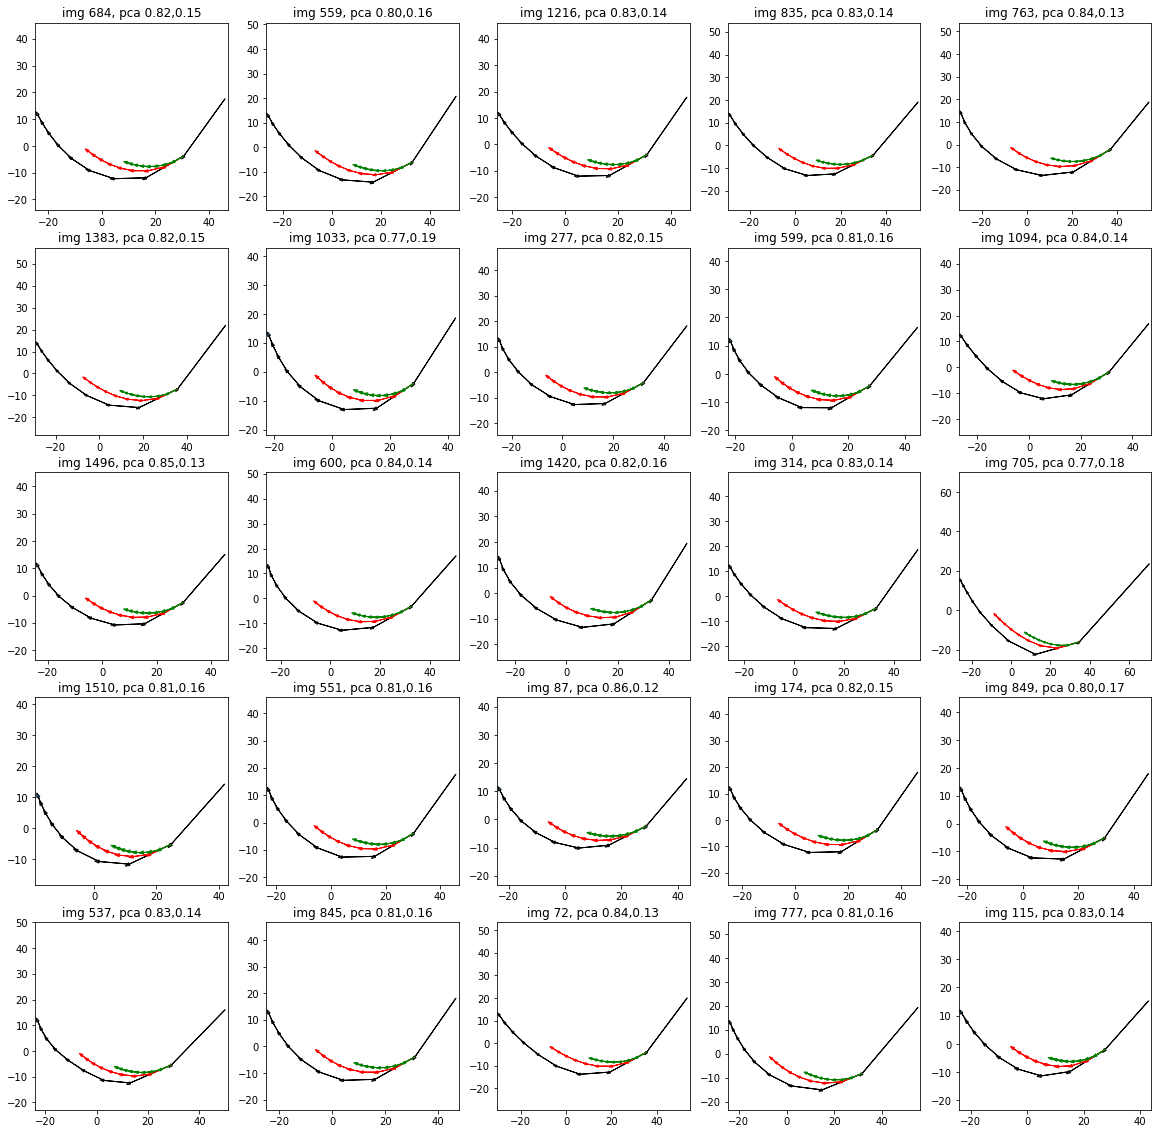

diff_overall           [0.2203063666820526, 0.12267972528934479, 0.08...
diff_per_image_mean    [0.2180402325373143, 0.12246004518587142, 0.08...
diff_per_image_std     [0.03112905148483118, 0.012838501494377411, 0....
corr_test                                                       0.685659
h5file                 /home/yimengzh/thesis-v2-large-files/maskcnn_p...
mean_diff_overall                                               0.077272
mean_diff_per_image                                            0.0770847
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


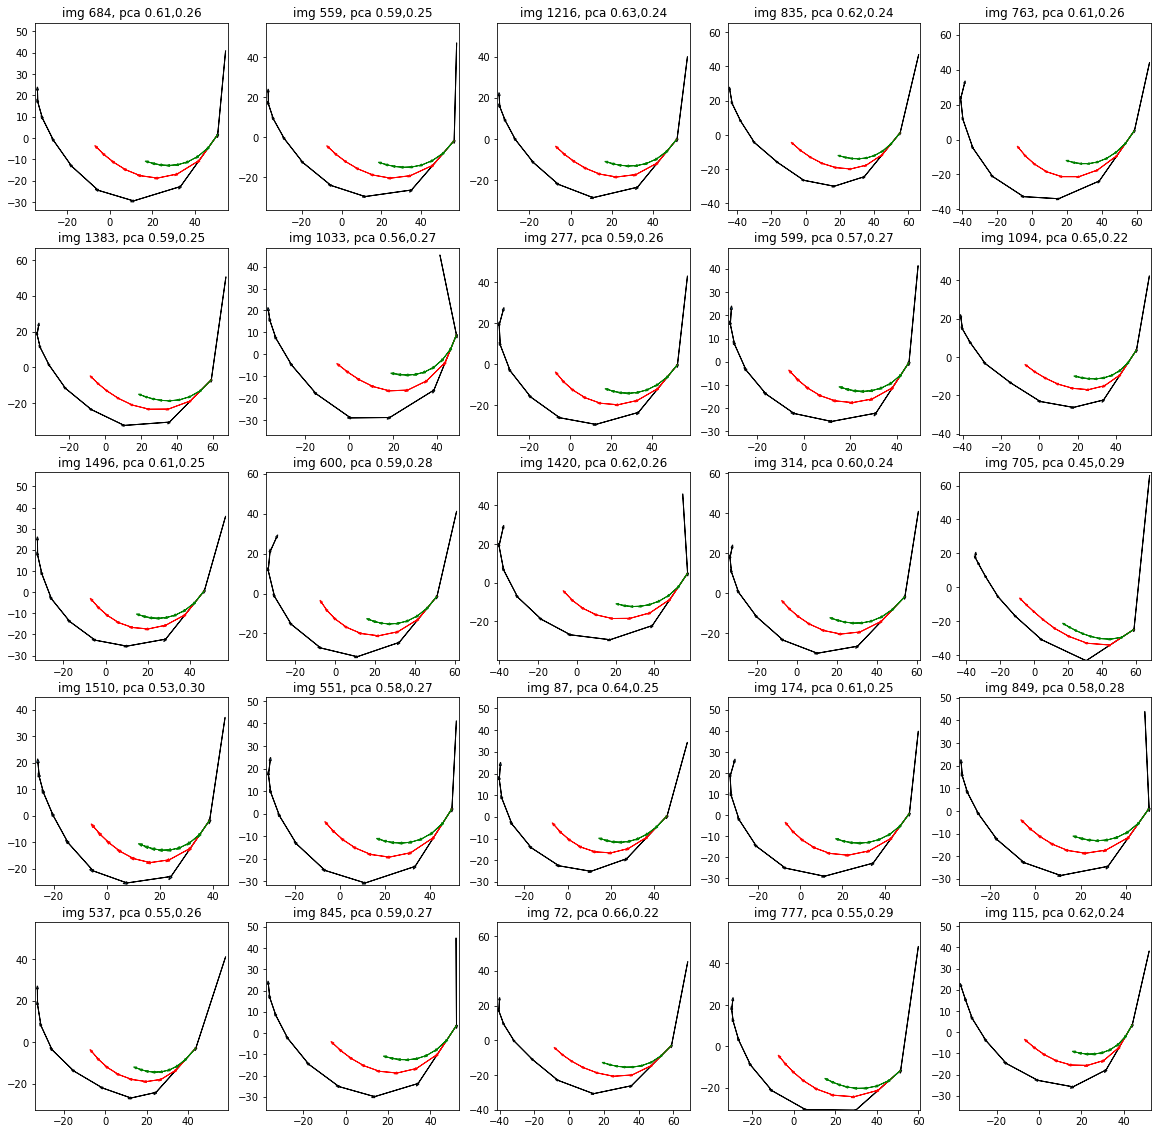

In [40]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], cls_to_use, 0)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], cls_to_use, 0, False)

diff_overall           [0.26835882663726807, 0.15091833472251892, 0.0...
diff_per_image_mean    [0.2712703137099743, 0.15272012217435985, 0.09...
diff_per_image_std     [0.038302807917459075, 0.020840067234388665, 0...
corr_test                                                       0.337821
h5file                 /home/yimengzh/thesis-v2-large-files/maskcnn_p...
mean_diff_overall                                               0.087542
mean_diff_per_image                                            0.0883265
Name: (1280, relu, poisson, 0.01, 5e-06, 2, 8, False), dtype: object


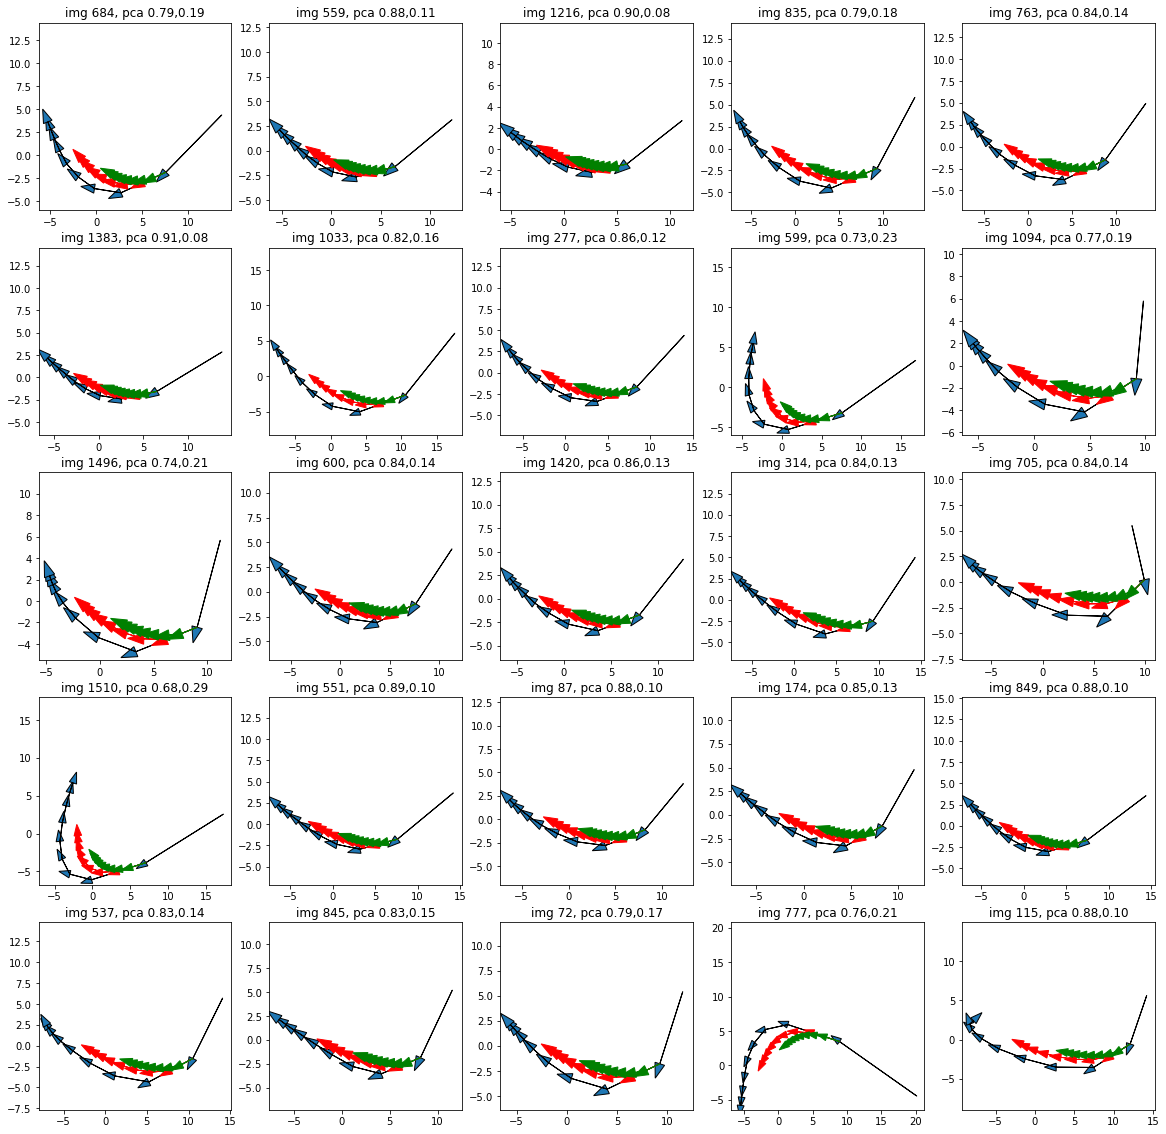

diff_overall           [0.26835882663726807, 0.15091833472251892, 0.0...
diff_per_image_mean    [0.2712703137099743, 0.15272012217435985, 0.09...
diff_per_image_std     [0.038302807917459075, 0.020840067234388665, 0...
corr_test                                                       0.337821
h5file                 /home/yimengzh/thesis-v2-large-files/maskcnn_p...
mean_diff_overall                                               0.087542
mean_diff_per_image                                            0.0883265
Name: (1280, relu, poisson, 0.01, 5e-06, 2, 8, False), dtype: object


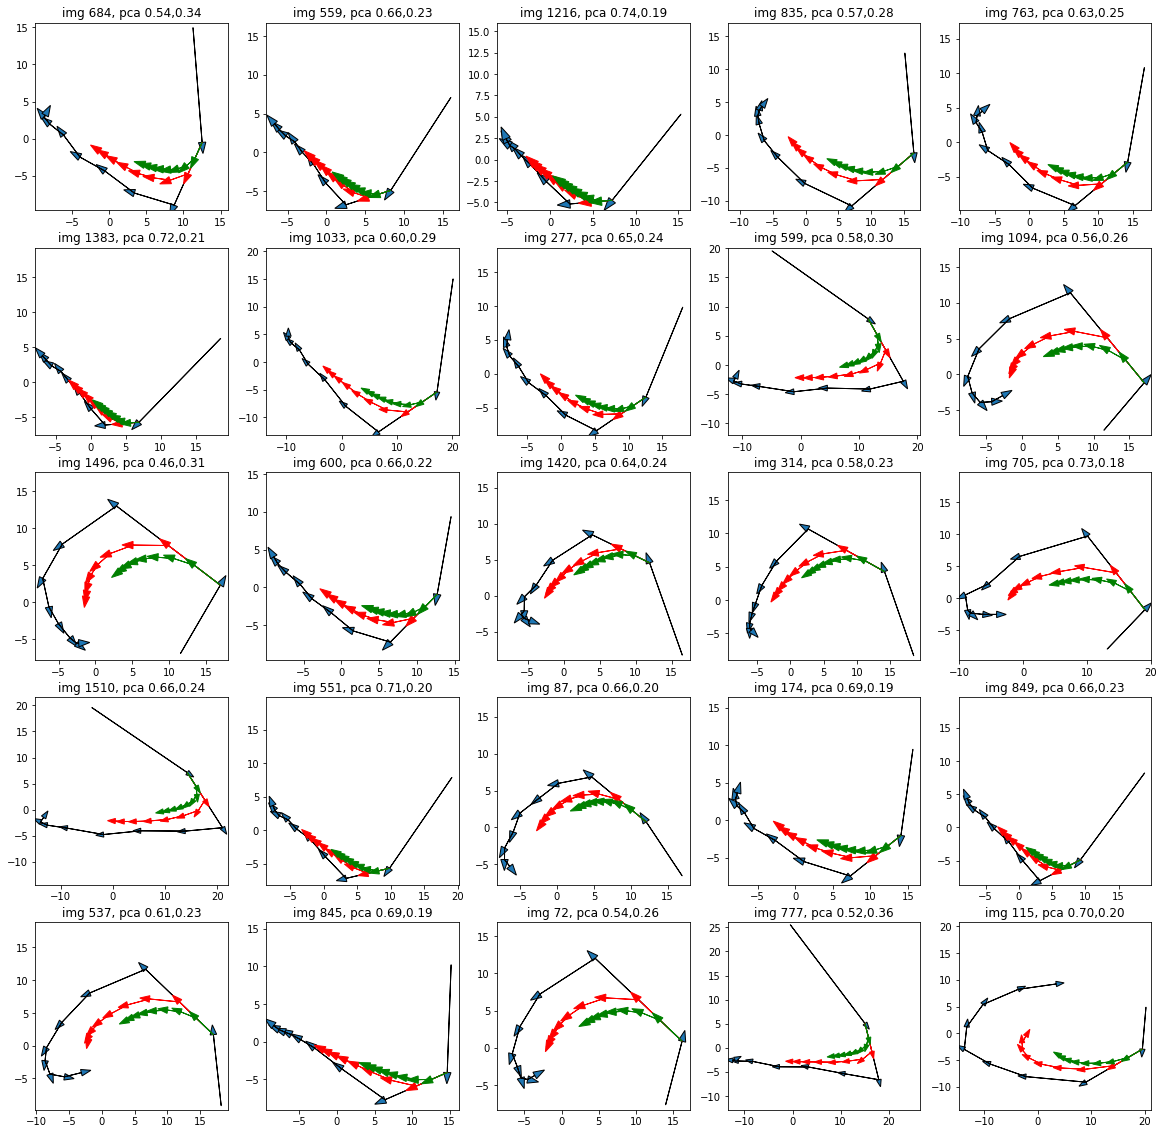

In [41]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], cls_to_use, 0)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], cls_to_use, 0, False)

diff_overall           [0.3090623915195465, 0.14594948291778564, 0.09...
diff_per_image_mean    [0.30847634074278174, 0.14781330921221525, 0.0...
diff_per_image_std     [0.03895388919524419, 0.01911868440001559, 0.0...
corr_test                                                       0.353127
h5file                 /home/yimengzh/thesis-v2-large-files/maskcnn_p...
mean_diff_overall                                              0.0936756
mean_diff_per_image                                            0.0941531
Name: (1280, relu, mse, 0.01, 5e-06, 2, 8, False), dtype: object


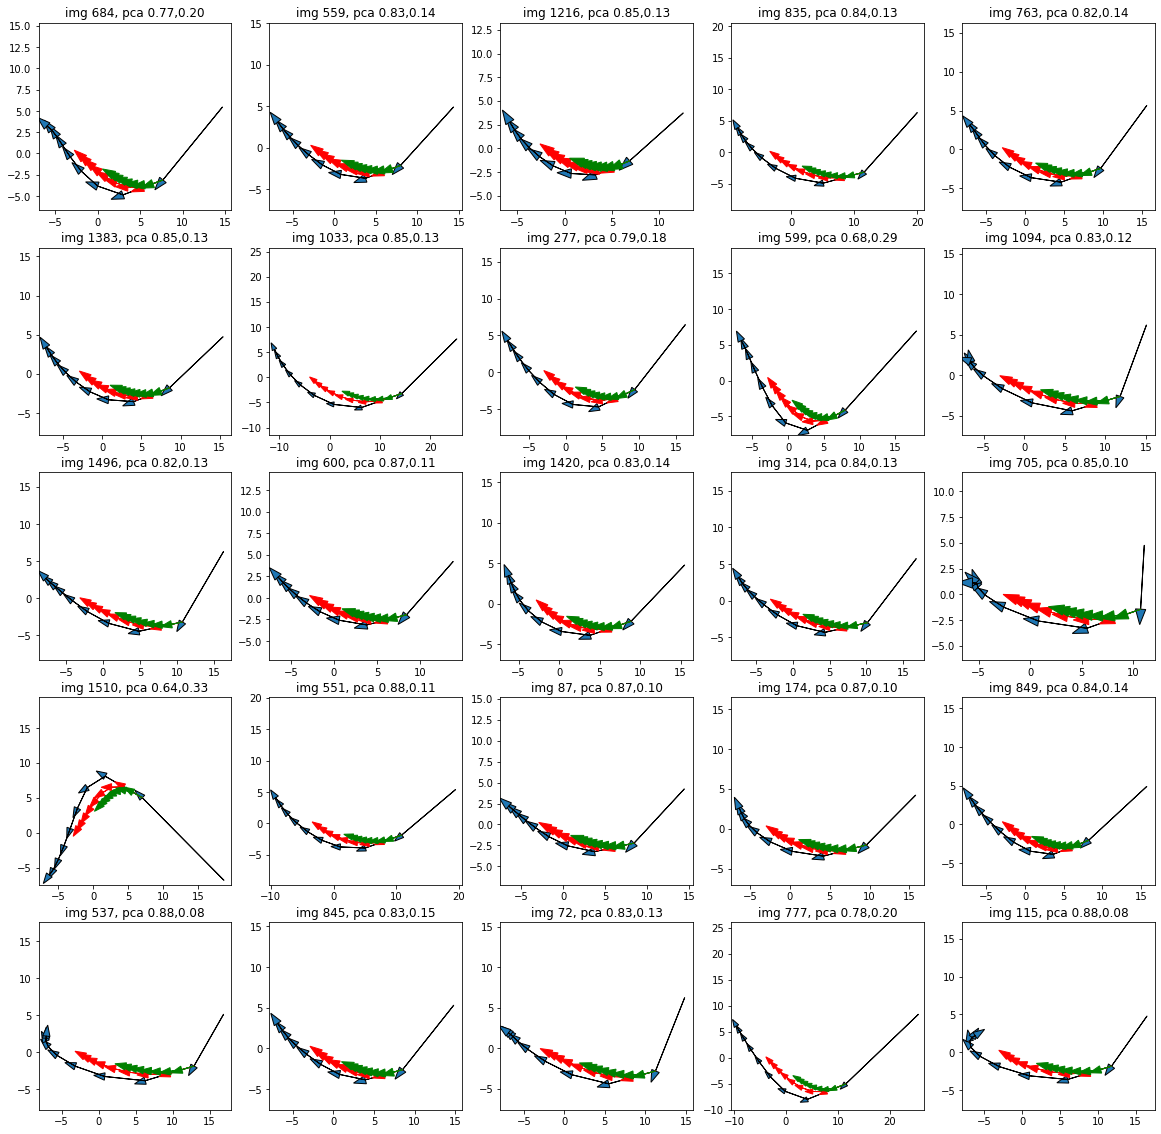

diff_overall           [0.3090623915195465, 0.14594948291778564, 0.09...
diff_per_image_mean    [0.30847634074278174, 0.14781330921221525, 0.0...
diff_per_image_std     [0.03895388919524419, 0.01911868440001559, 0.0...
corr_test                                                       0.353127
h5file                 /home/yimengzh/thesis-v2-large-files/maskcnn_p...
mean_diff_overall                                              0.0936756
mean_diff_per_image                                            0.0941531
Name: (1280, relu, mse, 0.01, 5e-06, 2, 8, False), dtype: object


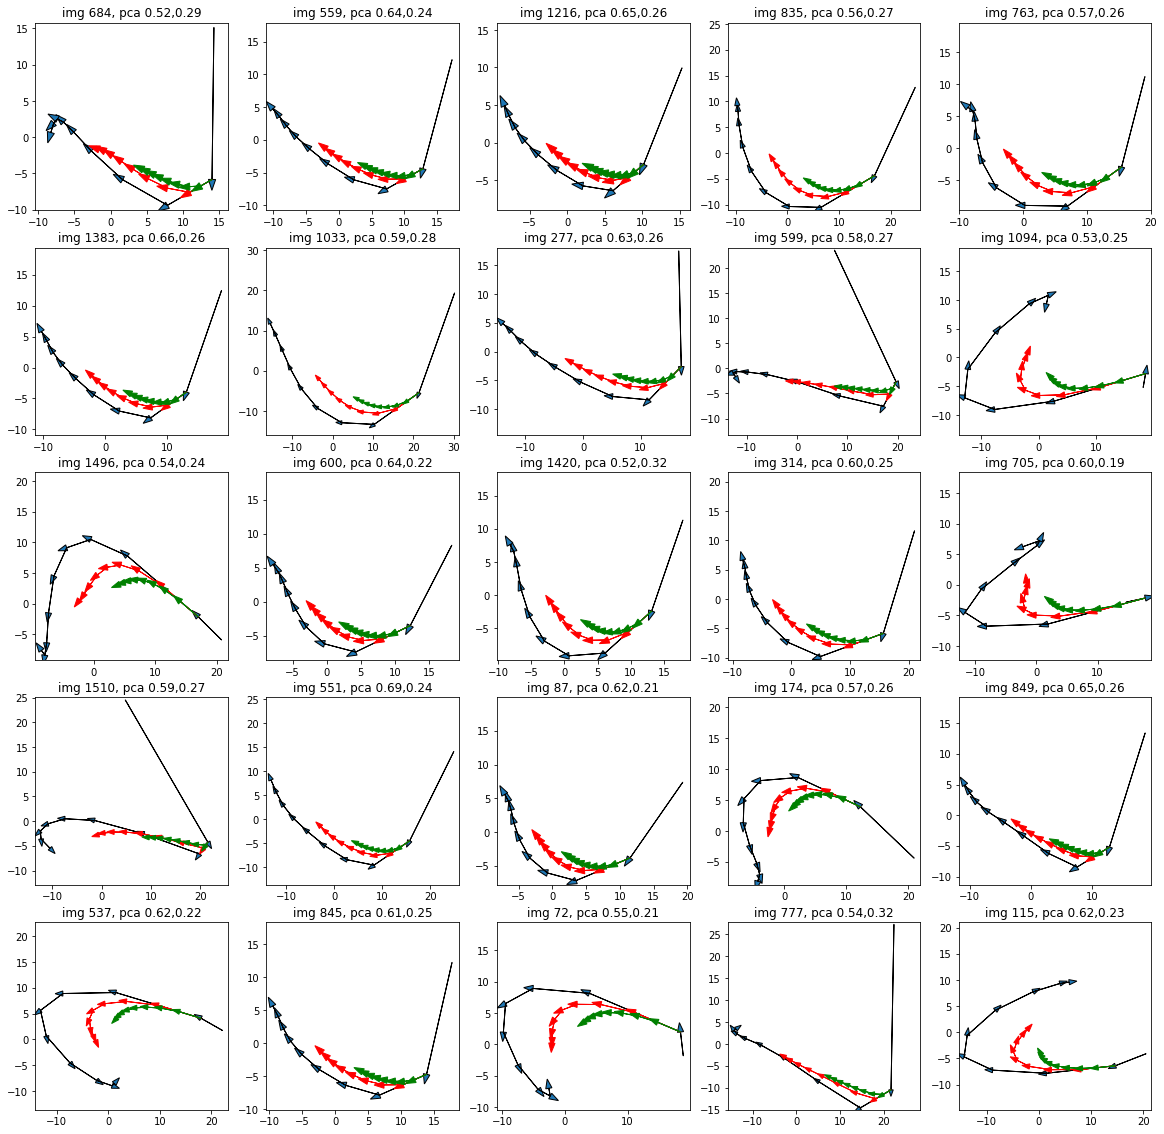

In [42]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-2], cls_to_use, 0)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-2], cls_to_use, 0, False)